In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium

In [39]:
df = pd.read_csv('data/df_full2.csv')
df.head()

,time,latitude,longitude,elevation,pointxyz,step_dist,mph,elevation_change,5sec_rolling_elv,second,elapsed_time,step_feet,cum_dist,moving_time
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0.0,NaN,0,0:00:00,0.000000,0.000000,0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,1.440858,0.0,NaN,1,0:00:01,2.113258,0.000400,1
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001188,4.277103,0.0,NaN,2,0:00:02,6.273084,0.001989,1
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001180,4.249086,0.0,NaN,3,0:00:03,6.231993,0.004357,1
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,7.422258,0.2,0.04,4,0:00:04,10.885979,0.007599,1


# Segments
 ### I want to assign a grade designation by some unit of distance (15 ft?  15 seconds? or consistant grade sticks together whether long or short?)
 
 ### I want to create segments @ natural stopping points (roads/lights/aid stations) where speed is close to 0. 
 ### do segments first, then get rid of the stopped areas (or just label them differently and can sum moving time by count and get "seconds
 ### cycle between moving seg1, stopped segment (i.e. time spent at aid or at light) and then after a stop then seg2 , and so on.

In [40]:
cum_dist = [0]
interim_cum_dist = 0
for i in range(1,len(df)):

    this_step = (df['step_dist'][i]+df['step_dist'][i-1])
    interim_cum_dist +=  this_step
    cum_dist.append(interim_cum_dist)

df['cum_dist'] = pd.Series(cum_dist)


In [41]:
def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

junder,jover = find_neighbours(1,df,'cum_dist')
df[junder:jover+1]


,time,latitude,longitude,elevation,pointxyz,step_dist,mph,elevation_change,5sec_rolling_elv,second,elapsed_time,step_feet,cum_dist,moving_time
231,2021-11-19 14:56:44+00:00,38.792259,-77.049761,0.2,"(38.79225891083479, -77.0497614517808, 0.20000...",0.002535,9.126972,0.0,0.20,231,0:03:51,13.386226,0.997360,1
232,2021-11-19 14:56:45+00:00,38.792225,-77.049773,0.2,"(38.7922253832221, -77.04977318644524, 0.20000...",0.002398,8.632458,0.0,0.12,232,0:03:52,12.660938,1.002293,1


In [42]:
print(df['cum_dist'][junder]//1)
print(df['cum_dist'][jover]//1)


0.0
1.0


In [43]:
# add mile indicators
def make_miles(row):
    return row['cum_dist']//1
df['mile'] = df.apply(make_miles, axis=1)
df['mile'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [37]:
df.tail()

,time,latitude,longitude,elevation,pointxyz,step_dist,mph,elevation_change,5sec_rolling_elv,second,step_feet,moving_time,15sec_rolling_elv,cum_dist,mile
4299,2021-11-19 16:04:32+00:00,38.795236,-77.045685,-21.6,"(38.7952355761081, -77.04568499699235, -21.600...",0.002134,7.682124,0.000000,-0.04,4299,11.267115,1,0.013333,16.839805,16.0
4300,2021-11-19 16:04:33+00:00,38.795267,-77.045679,-21.6,"(38.79526692442596, -77.04567896202207, -21.60...",0.002187,7.872447,0.000000,0.00,4300,11.546256,1,0.013333,16.844126,16.0
4301,2021-11-19 16:04:34+00:00,38.795301,-77.045674,-21.6,"(38.79530120640993, -77.04567359760404, -21.60...",0.002382,8.576695,0.000000,0.00,4301,12.579153,1,0.013333,16.848695,16.0
4302,2021-11-19 16:04:35+00:00,38.795327,-77.045666,-21.6,"(38.79532660357654, -77.04566630534828, -21.60...",0.001796,6.464028,0.000000,0.00,4302,9.480575,1,0.013333,16.852873,16.0
4303,2021-11-19 16:04:36+00:00,38.795349,-77.045664,-21.4,"(38.79534940235317, -77.04566420987248, -21.39...",0.001581,5.692567,0.200001,0.04,4303,8.349099,1,0.013333,16.856250,16.0


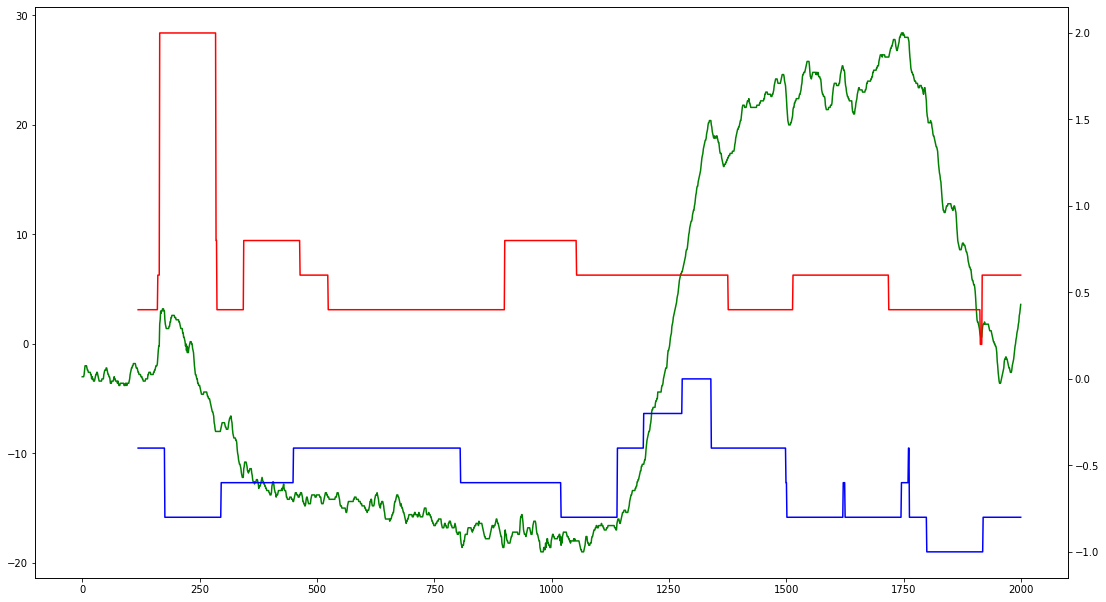

In [44]:
# Experiment with mean max and min on rolling elevation change
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index[0:2000],df['elevation'][0:2000], c='g')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(60).mean()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).max()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).min()[0:2000], c='b')



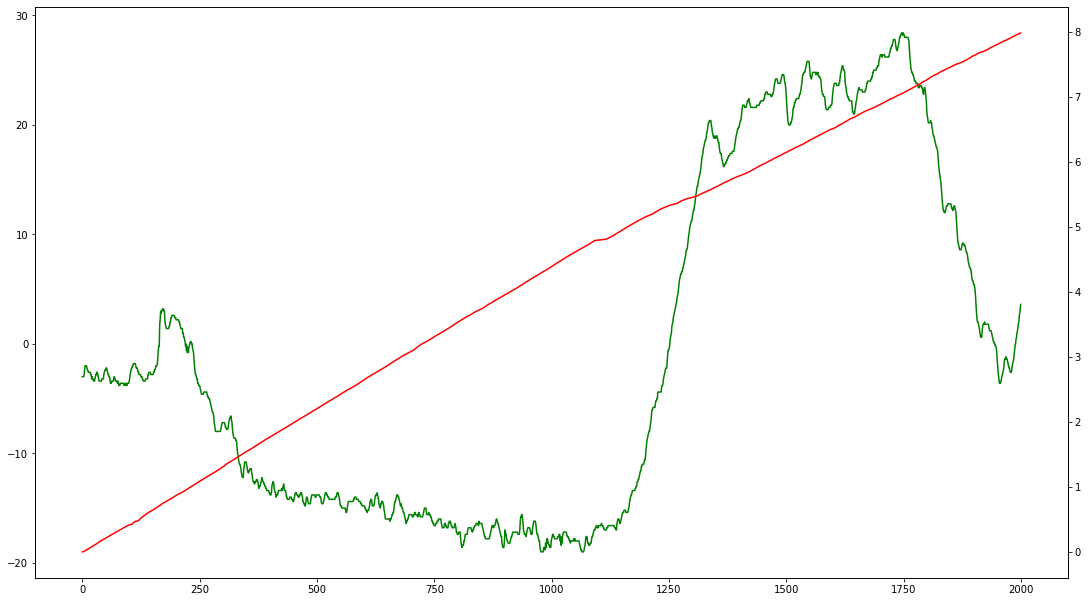

In [45]:
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index[0:2000],df['elevation'][0:2000], c='g')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(60).mean()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['cum_dist'][0:2000], c='r')